## Rapamycin specific direction flip shift

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [ ]:
# 1. Load data & define cytokines
df = pd.read_csv("cytokine_dataset_post_mice_imputation_expt46.csv")
meta = ["experiment_number","timepoint","mouse","Genotype","treatment","observation"]
cytokines = [c for c in df.columns if c not in meta]

# 2. Compute baseline means (Before) for untreated
base = df[(df.timepoint=="observation before rapamycin") & (df.treatment==False)]
wt0  = base[base.Genotype=="WT"][cytokines].mean()
mut0 = base[base.Genotype=="Mut"][cytokines].mean()

# 3. Function to compute adjusted log2FC ##***Baseline correction**###
def compute_fc(d, treated_flag):
    tps = ["observation before rapamycin","observation during rapamycin","observation after rapamycin"]
    out = {}
    sub = d[d.treatment==treated_flag]
    for tp in tps:
        grp = sub[sub.timepoint==tp]
        wt  = grp[grp.Genotype=="WT"][cytokines].mean()
        mut = grp[grp.Genotype=="Mut"][cytokines].mean()
        rel_wt  = (wt+1)/(wt0+1)
        rel_mut = (mut+1)/(mut0+1)
        out[tp] = np.log2(rel_mut/rel_wt)
    dfc = pd.DataFrame(out)
    return dfc.rename(columns={
        "observation before rapamycin":"Before",
        "observation during rapamycin":"During",
        "observation after rapamycin":"After"
    })

fc_u = compute_fc(df, False)  # Untreated
fc_t = compute_fc(df, True)   # Treated

# 4. Identify pure direction flips (no threshold)
d_col, a_col = "During", "After"
temp_shifts = {
    cyto: ("UpDir" if fc_u.loc[cyto,d_col]<0<fc_u.loc[cyto,a_col]
                 else "DownDir" if fc_u.loc[cyto,d_col]>0>fc_u.loc[cyto,a_col]
                 else "NoFlip")
    for cyto in cytokines
}
rapa_shifts = {
    cyto: ("UpDir" if fc_t.loc[cyto,d_col]<0<fc_t.loc[cyto,a_col]
                 else "DownDir" if fc_t.loc[cyto,d_col]>0>fc_t.loc[cyto,a_col]
                 else "NoFlip")
    for cyto in cytokines
}

# Build DataFrames
df_temp = pd.DataFrame(list(temp_shifts.items()), columns=["Cytokine","Shift"])
df_rapa = pd.DataFrame(list(rapa_shifts.items()), columns=["Cytokine","Shift"])

# 5. Compare for rapamycin-specific flips
def compare(u,t):
    if t in ["UpDir","DownDir"] and u==t: return "same_in_untreated"
    if t in ["UpDir","DownDir"] and u!=t: return "rapamycin_specific"
    return "no_flip"

df_spec = df_rapa.copy()
df_spec["Comparison"] = [compare(temp_shifts[c], rapa_shifts[c]) for c in cytokines]

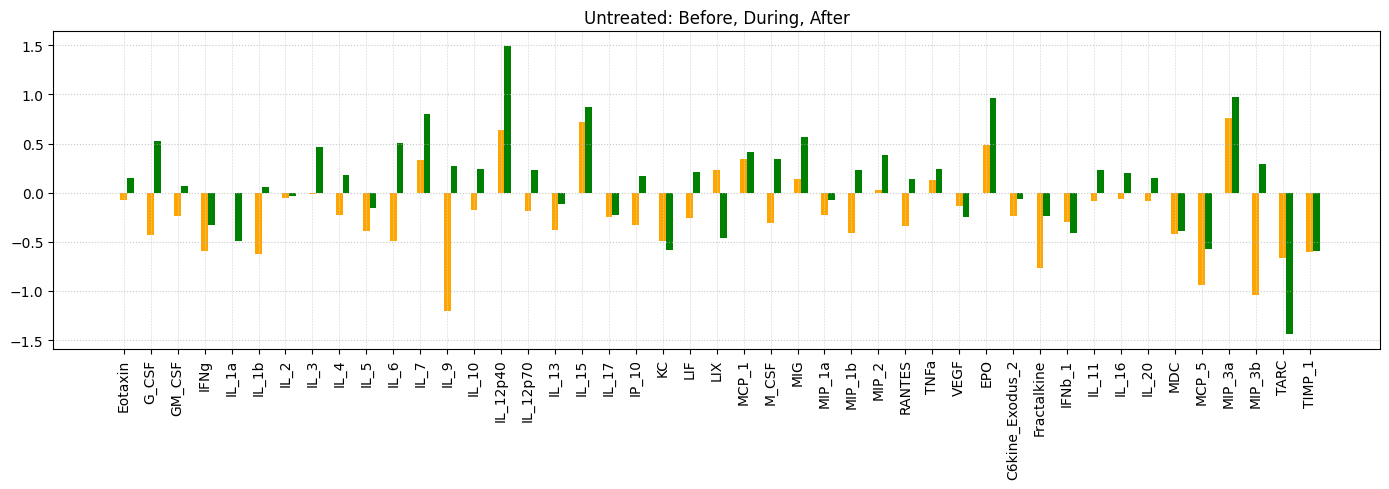

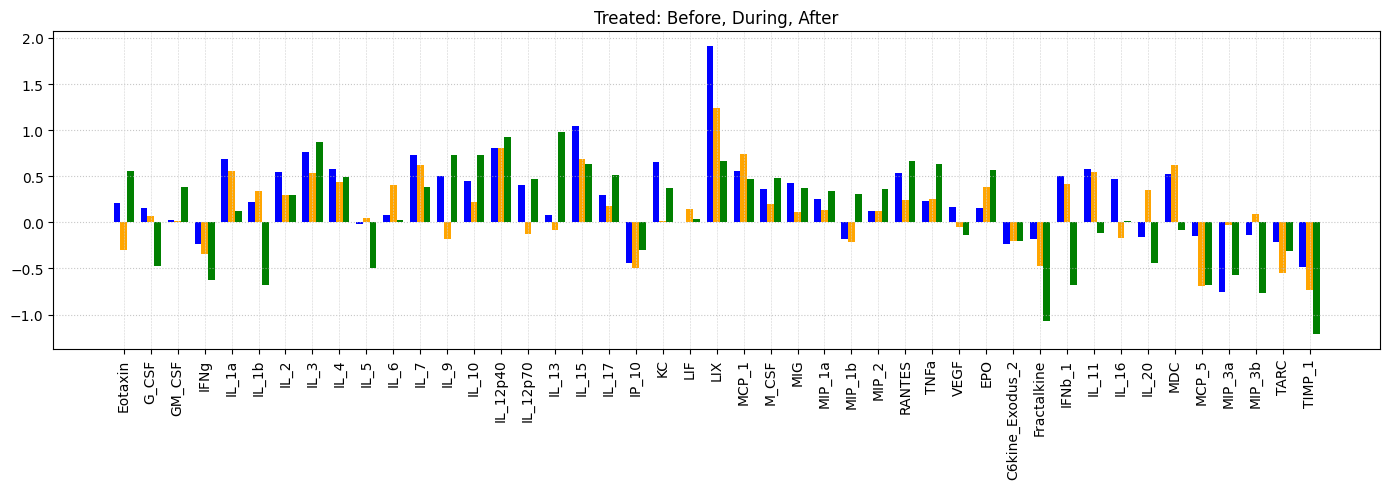

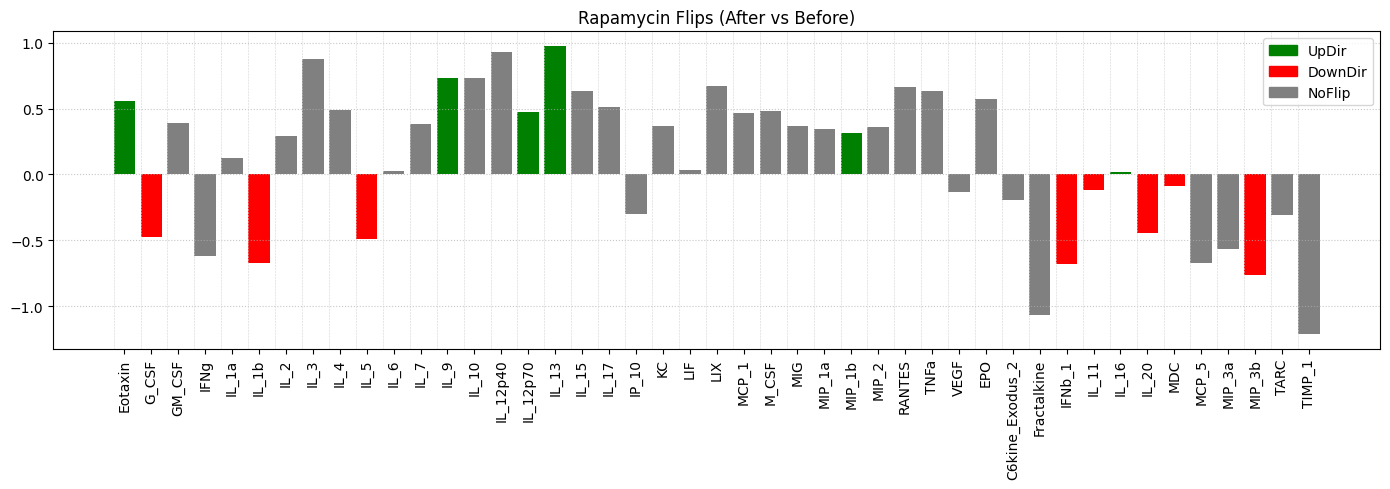

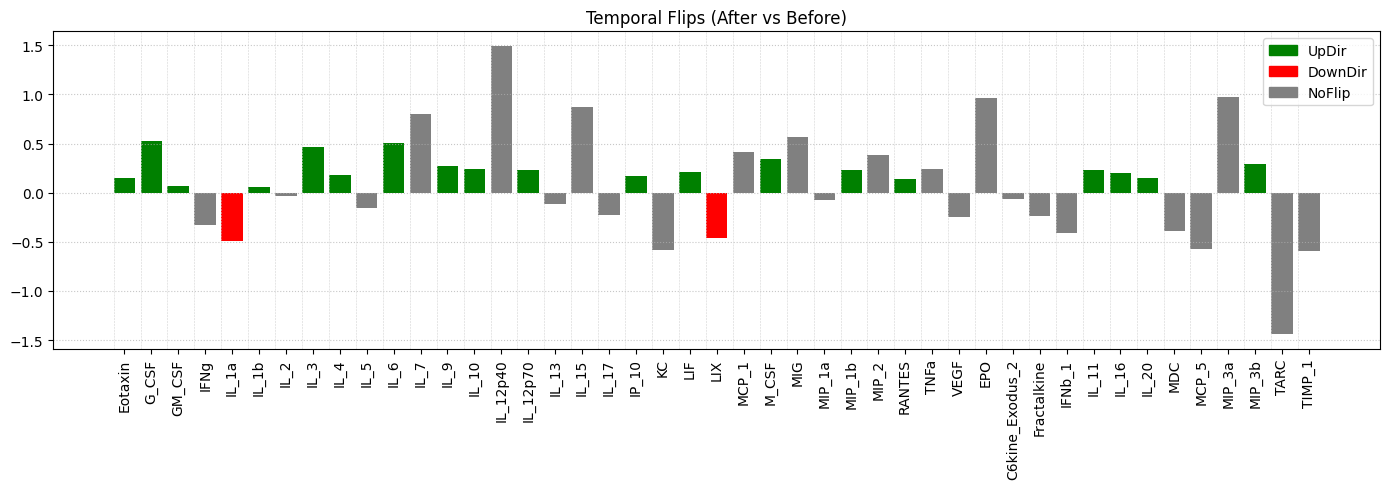

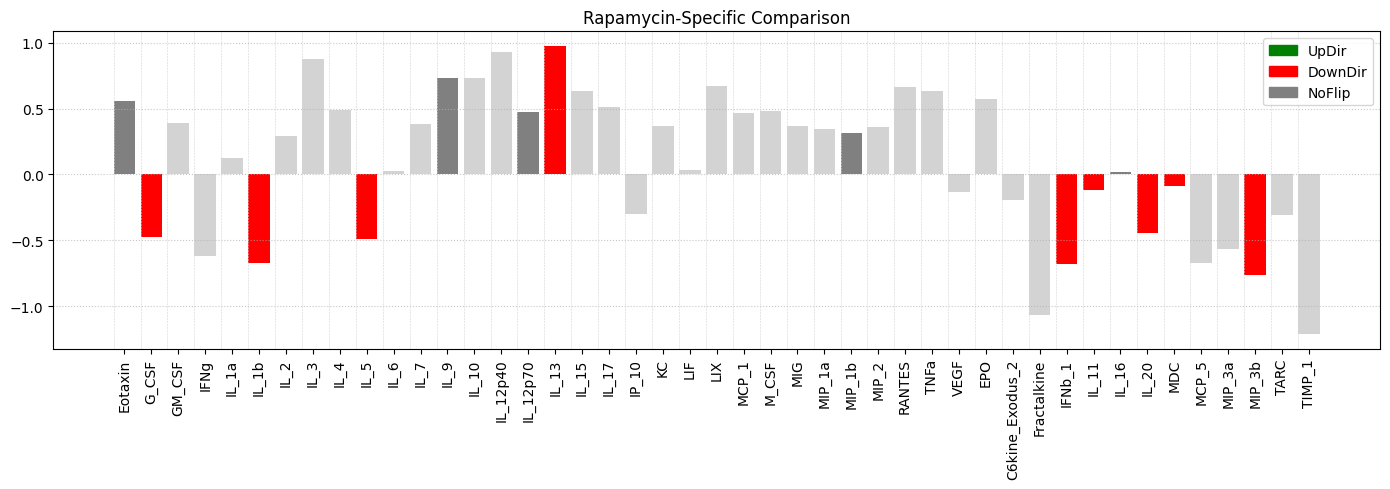

In [6]:
# 6. Plot settings
pos = np.arange(len(cytokines)); w=0.25

# 6.1 Untreated multi-timepoint
plt.figure(figsize=(14,5))
plt.bar(pos-w, fc_u["Before"], width=w, color="blue")
plt.bar(pos,   fc_u["During"], width=w, color="orange")
plt.bar(pos+w, fc_u["After"],  width=w, color="green")
plt.xticks(pos, cytokines, rotation=90); plt.title("Untreated: Before, During, After")
plt.grid(axis="y", linestyle=":", alpha=0.7)
for x in pos: plt.axvline(x, color="lightgrey", linestyle="--", linewidth=0.4)
plt.tight_layout(); plt.show()

# 6.2 Treated multi-timepoint
plt.figure(figsize=(14,5))
plt.bar(pos-w, fc_t["Before"], width=w, color="blue")
plt.bar(pos,   fc_t["During"], width=w, color="orange")
plt.bar(pos+w, fc_t["After"],  width=w, color="green")
plt.xticks(pos, cytokines, rotation=90); plt.title("Treated: Before, During, After")
plt.grid(axis="y", linestyle=":", alpha=0.7)
for x in pos: plt.axvline(x, color="lightgrey", linestyle="--", linewidth=0.4)
plt.tight_layout(); plt.show()

# 6.3 Rapamycin flips per cytokine
colors_r = {"UpDir":"green","DownDir":"red","NoFlip":"grey"}
vals_r = [fc_t.loc[c,a_col] for c in cytokines]
cols_r = [colors_r[rapa_shifts[c]] for c in cytokines]
plt.figure(figsize=(14,5))
bars = plt.bar(cytokines, vals_r, color=cols_r)
plt.xticks(rotation=90); plt.title("Rapamycin Flips (After vs Before)")
plt.grid(axis="y", linestyle=":", alpha=0.7)
for b in bars: plt.axvline(b.get_x(), color="lightgrey", linestyle="--", linewidth=0.4)
patches = [Patch(color=c, label=l) for l, c in colors_r.items()]
plt.legend(handles=patches, loc="upper right")
#plt.legend([Patch(color=c, label=l) for l,c in colors_r.items()], loc="upper right")
plt.tight_layout(); plt.show()

# 6.4 Temporal flips per cytokine
cols_u = [colors_r[temp_shifts[c]] for c in cytokines]
plt.figure(figsize=(14,5))
bars = plt.bar(cytokines, [fc_u.loc[c,a_col] for c in cytokines], color=cols_u)
plt.xticks(rotation=90); plt.title("Temporal Flips (After vs Before)")
plt.grid(axis="y", linestyle=":", alpha=0.7)
for b in bars: plt.axvline(b.get_x(), color="lightgrey", linestyle="--", linewidth=0.4)
patches = [Patch(color=c, label=l) for l, c in colors_r.items()]
plt.legend(handles=patches, loc="upper right")
#plt.legend([Patch(color=c, label=l) for l,c in colors_r.items()], loc="upper right")
plt.tight_layout(); plt.show();

# 6.5 Rapamycin-specific comparison per cytokine
colors_s = {"same_in_untreated":"grey","rapamycin_specific":"red","no_flip":"lightgrey"}
vals_s = [fc_t.loc[c,a_col] for c in cytokines]
cols_s = [colors_s[df_spec.loc[df_spec.Cytokine==c,"Comparison"].values[0]] for c in cytokines]
plt.figure(figsize=(14,5))
bars = plt.bar(cytokines, vals_s, color=cols_s)
plt.xticks(rotation=90); plt.title("Rapamycin-Specific Comparison")
plt.grid(axis="y", linestyle=":", alpha=0.7)
for b in bars: plt.axvline(b.get_x(), color="lightgrey", linestyle="--", linewidth=0.4)
patches = [Patch(color=c, label=l) for l, c in colors_r.items()]
plt.legend(handles=patches, loc="upper right")
#plt.legend([Patch(color=c, label=l) for l,c in colors_s.items()], loc="upper right")
plt.tight_layout(); plt.show();


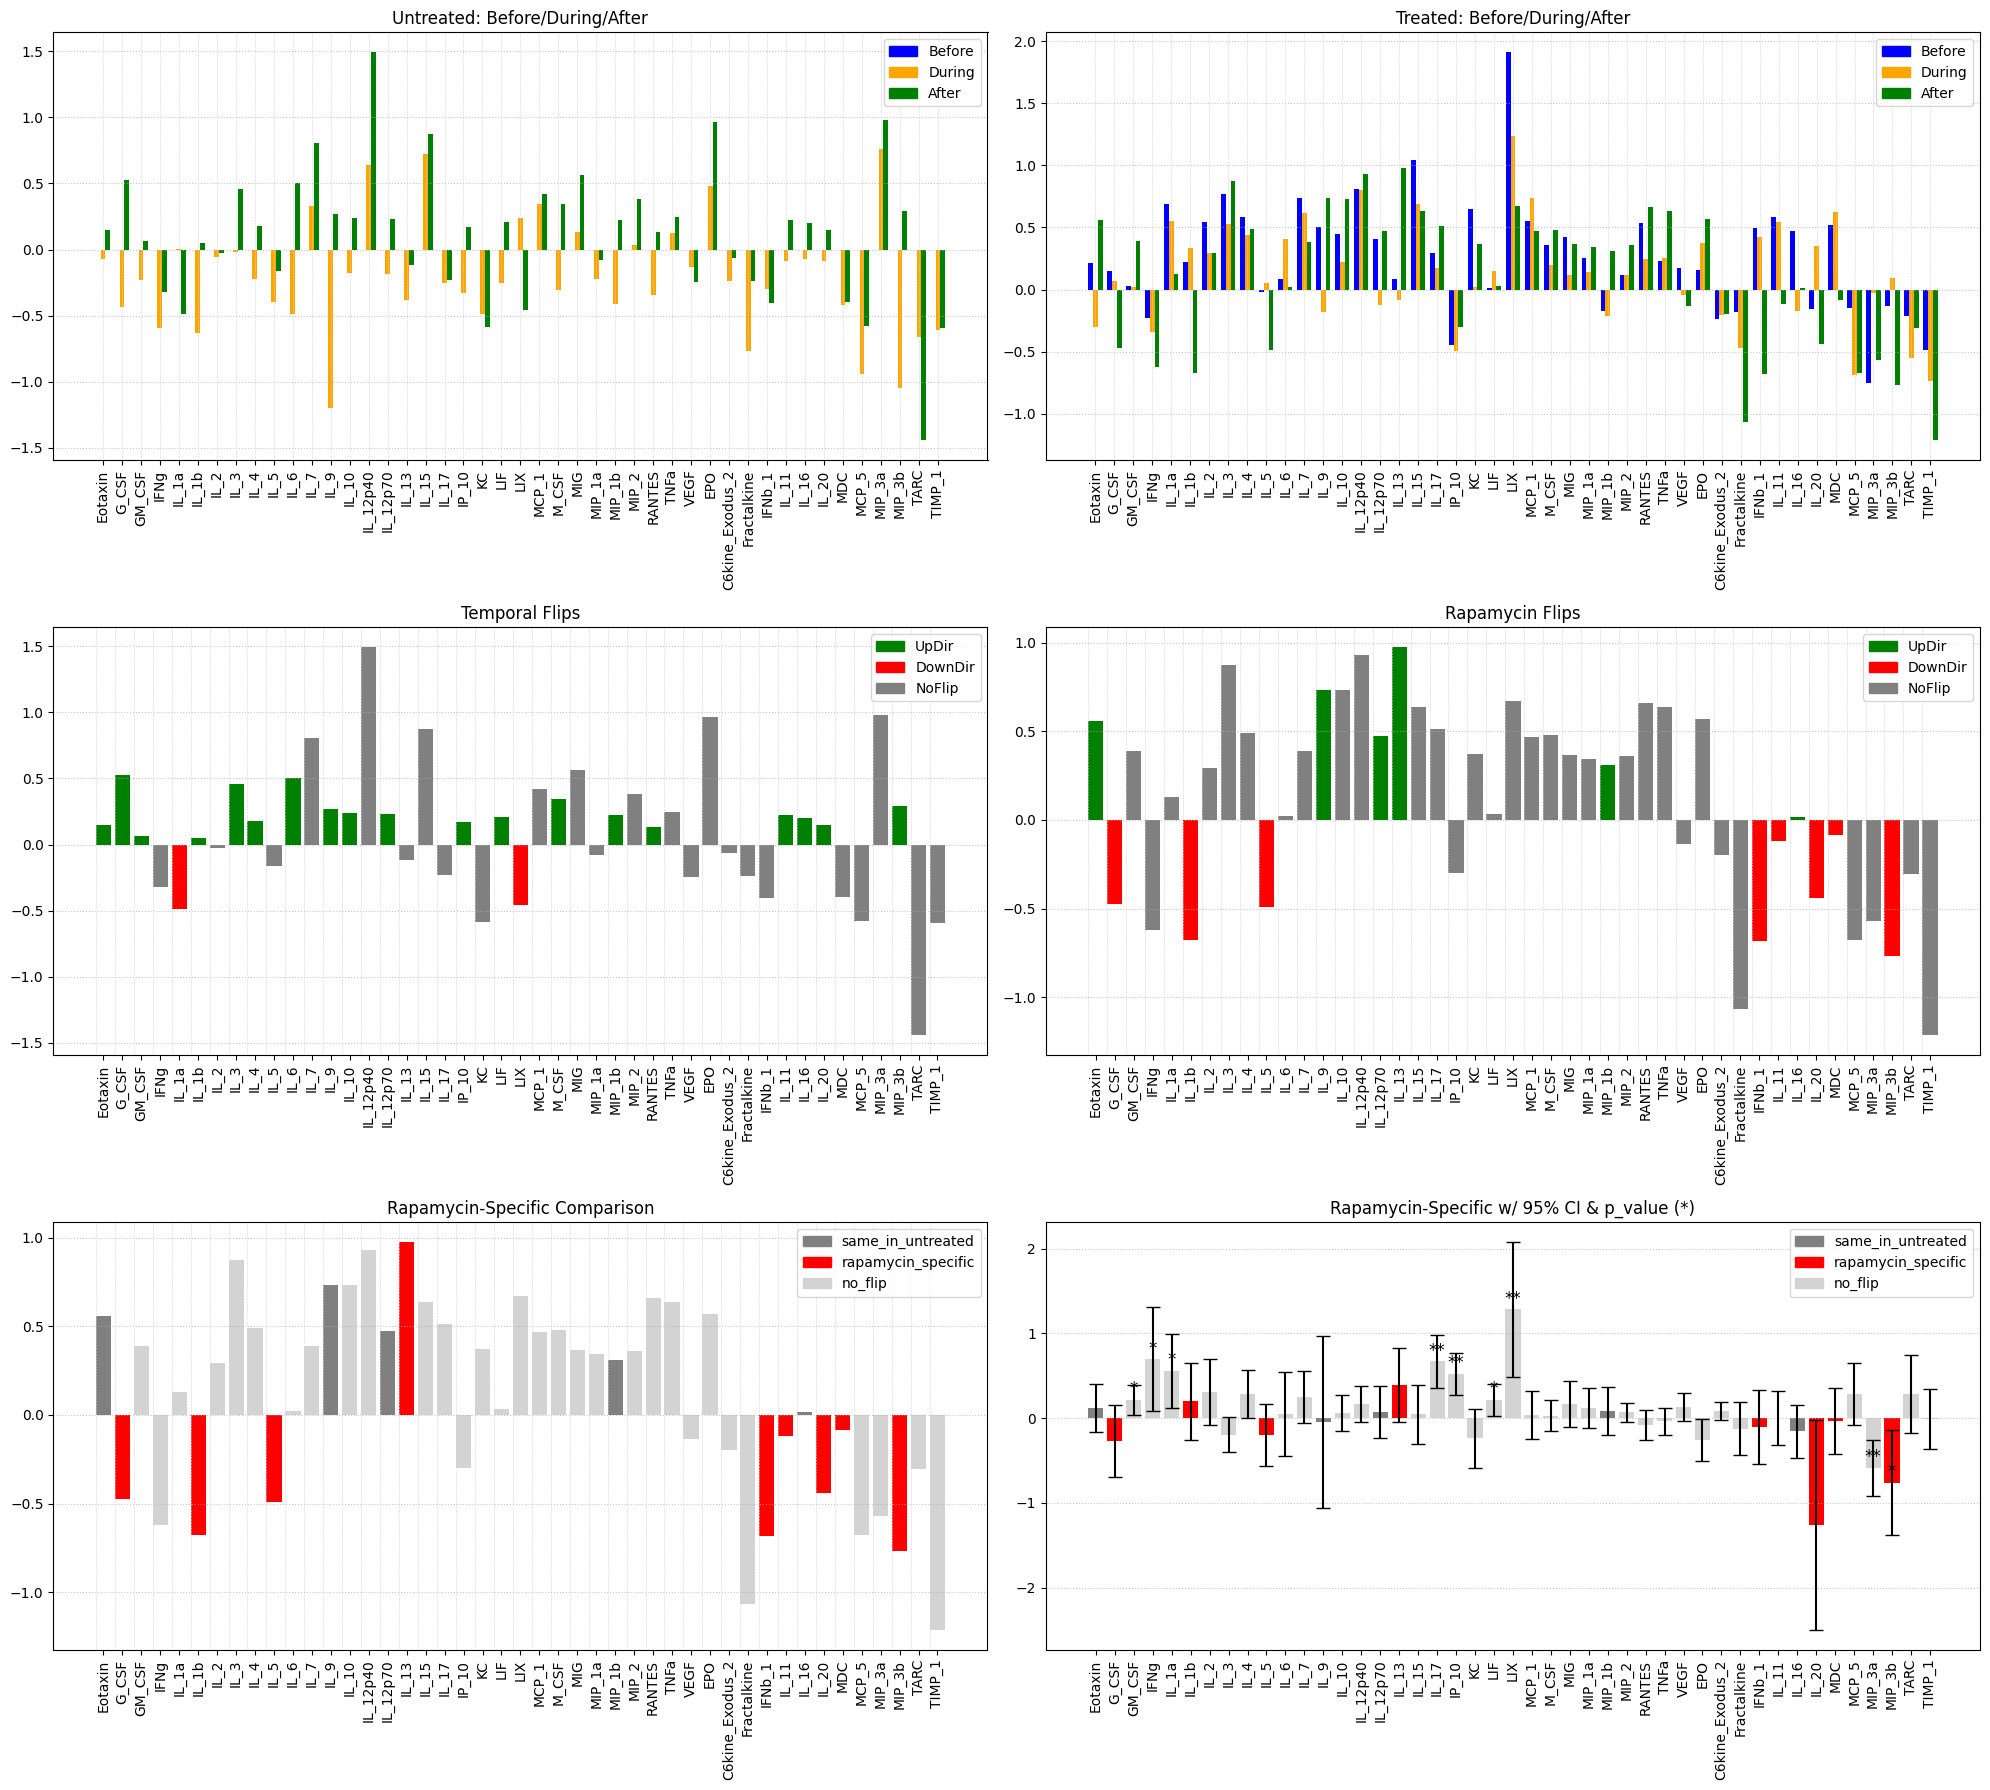

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.patches import Patch

# 1. Load data
df = pd.read_csv("cytokine_dataset_post_mice_imputation_expt46.csv")
exclude = ["experiment_number","timepoint","mouse","Genotype","treatment","observation"]
cytokines = [c for c in df.columns if c not in exclude]

# 2. Baseline means
base = df[(df.timepoint=="observation before rapamycin") & (df.treatment==False)]
wt0  = base[base.Genotype=="WT"][cytokines].mean()
mut0 = base[base.Genotype=="Mut"][cytokines].mean()

# 3. Compute log2FC
def compute_fc(d, flag):
    tps = ["observation before rapamycin",
           "observation during rapamycin",
           "observation after rapamycin"]
    out = {}
    sub = d[d.treatment==flag]
    for tp in tps:
        grp = sub[sub.timepoint==tp]
        wt  = grp[grp.Genotype=="WT"][cytokines].mean()
        mut = grp[grp.Genotype=="Mut"][cytokines].mean()
        out[tp] = np.log2((mut+1)/(wt+1) / ((mut0+1)/(wt0+1)))
    dfc = pd.DataFrame(out).rename(columns={
        tps[0]:"Before", tps[1]:"During", tps[2]:"After"
    })
    return dfc

fc_u = compute_fc(df, False)
fc_t = compute_fc(df, True)

# 4. Pure direction flips
d, a = "During", "After"
temp_shifts = {c: ("UpDir" if fc_u.loc[c,d]<0<fc_u.loc[c,a]
                   else "DownDir" if fc_u.loc[c,d]>0>fc_u.loc[c,a]
                   else "NoFlip")
               for c in cytokines}
rapa_shifts = {c: ("UpDir" if fc_t.loc[c,d]<0<fc_t.loc[c,a]
                   else "DownDir" if fc_t.loc[c,d]>0>fc_t.loc[c,a]
                   else "NoFlip")
               for c in cytokines}

# 5. Build DataFrames & comparison
df_temp = pd.DataFrame(temp_shifts.items(), columns=["Cytokine","Shift"])
df_rapa = pd.DataFrame(rapa_shifts.items(), columns=["Cytokine","Shift"])
def cmp(u,t):
    if t in ["UpDir","DownDir"] and u==t: return "same_in_untreated"
    if t in ["UpDir","DownDir"] and u!=t: return "rapamycin_specific"
    return "no_flip"
df_spec = df_rapa.copy()
df_spec["Comparison"] = [cmp(temp_shifts[c], rapa_shifts[c]) for c in cytokines]

# 6. Stats for CI & stars
df_treated = df[df.treatment==True]
df_d = df_treated[df_treated.timepoint=="observation during rapamycin"].set_index("mouse")
df_a = df_treated[df_treated.timepoint=="observation after rapamycin"].set_index("mouse")
mean_diff, ci_lo, ci_hi, stars = [], [], [], []
for c in cytokines:
    dat = pd.DataFrame({
        "dur": np.log2(df_d[c]+1),
        "aft": np.log2(df_a[c]+1)
    }).dropna()
    dif = dat.aft - dat.dur
    n = len(dif)
    m = dif.mean(); sem = dif.std(ddof=1)/np.sqrt(n) if n>1 else 0
    ci = 1.96*sem; p = stats.ttest_rel(dat.aft, dat.dur).pvalue if n>1 else np.nan
    mean_diff.append(m); ci_lo.append(m-ci); ci_hi.append(m+ci)
    stars.append("**" if p<0.01 else "*" if p<0.05 else "")

# 7. Plot all in 3x2 grid
fig, axes = plt.subplots(3,2, figsize=(20,18))
pos = np.arange(len(cytokines)); w=0.25

# 7.1 Untreated multi-timepoint
ax = axes[0,0]
ax.bar(pos-w, fc_u.Before, w, color="blue")
ax.bar(pos,   fc_u.During, w, color="orange")
ax.bar(pos+w, fc_u.After,   w, color="green")
ax.set_title("Untreated: Before/During/After")
ax.set_xticks(pos); ax.set_xticklabels(cytokines, rotation=90)
ax.grid(axis="y", linestyle=":", alpha=0.7)
# legend
leg1 = [Patch(color=c, label=l) for l,c in zip(["Before","During","After"],["blue","orange","green"])]
ax.legend(handles=leg1, loc="upper right")
for x in pos: ax.axvline(x, color="lightgrey", linestyle="--", linewidth=0.4)

# 7.2 Treated multi-timepoint
ax = axes[0,1]
ax.bar(pos-w, fc_t.Before, w, color="blue")
ax.bar(pos,   fc_t.During, w, color="orange")
ax.bar(pos+w, fc_t.After,   w, color="green")
ax.set_title("Treated: Before/During/After")
ax.set_xticks(pos); ax.set_xticklabels(cytokines, rotation=90)
ax.grid(axis="y", linestyle=":", alpha=0.7)
ax.legend(handles=leg1, loc="upper right")
for x in pos: ax.axvline(x, color="lightgrey", linestyle="--", linewidth=0.4)

# 7.3 Temporal flips
ax = axes[1,0]
colors_r = {"UpDir":"green","DownDir":"red","NoFlip":"grey"}
cols_u = [colors_r[temp_shifts[c]] for c in cytokines]
bars = ax.bar(cytokines, [fc_u.loc[c,a] for c in cytokines], color=cols_u)
ax.set_title("Temporal Flips")
ax.set_xticks(pos); ax.set_xticklabels(cytokines, rotation=90)
ax.grid(axis="y", linestyle=":", alpha=0.7)
patches_r = [Patch(color=v,label=k) for k,v in colors_r.items()]
ax.legend(handles=patches_r, loc="upper right")
for b in bars: ax.axvline(b.get_x(), color="lightgrey", linestyle="--", linewidth=0.4)

# 7.4 Rapamycin flips
ax = axes[1,1]
cols_r = [colors_r[rapa_shifts[c]] for c in cytokines]
bars = ax.bar(cytokines, [fc_t.loc[c,a] for c in cytokines], color=cols_r)
ax.set_title("Rapamycin Flips")
ax.set_xticks(pos); ax.set_xticklabels(cytokines, rotation=90)
ax.grid(axis="y", linestyle=":", alpha=0.7)
ax.legend(handles=patches_r, loc="upper right")
for b in bars: ax.axvline(b.get_x(), color="lightgrey", linestyle="--", linewidth=0.4)

# 7.5 Rapamycin-specific comparison
ax = axes[2,0]
colors_s = {"same_in_untreated":"grey","rapamycin_specific":"red","no_flip":"lightgrey"}
cols_s = [colors_s[df_spec.loc[df_spec.Cytokine==c,"Comparison"].iloc[0]] for c in cytokines]
bars = ax.bar(cytokines, [fc_t.loc[c,a] for c in cytokines], color=cols_s)
ax.set_title("Rapamycin-Specific Comparison")
ax.set_xticks(pos); ax.set_xticklabels(cytokines, rotation=90)
ax.grid(axis="y", linestyle=":", alpha=0.7)
patches_s = [Patch(color=v,label=k) for k,v in colors_s.items()]
ax.legend(handles=patches_s, loc="upper right")
for b in bars: ax.axvline(b.get_x(), color="lightgrey", linestyle="--", linewidth=0.4)

# 7.6 Rapamycin-specific CI & stars
ax = axes[2,1]
bars = ax.bar(cytokines, mean_diff,
    yerr=[np.array(mean_diff)-np.array(ci_lo), np.array(ci_hi)-np.array(mean_diff)],
    color=[colors_s[df_spec.loc[df_spec.Cytokine==c,"Comparison"].iloc[0]] for c in cytokines],
    capsize=5)
ax.set_title("Rapamycin-Specific w/ 95% CI & p_value (*)")
ax.set_xticks(pos); ax.set_xticklabels(cytokines, rotation=90)
ax.grid(axis="y", linestyle=":", alpha=0.7)
for bar, star in zip(bars, stars):
    if star:
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02, star,
                ha="center", va="bottom", fontsize=12)
ax.legend(handles=patches_s, loc="upper right")

# 8. Save combined figure
plt.tight_layout()
fig.savefig("all_cytokine_plots_rapa_specific_dir.png", dpi=600)
plt.show()


SUMMARY:

G_CSF, 
IL_1b, 
IL_5, 
IL_13 (UP in mutant)
IFNb_1, 
IL_11, 
IL_20, 
MDC,
MIP_3b